In [1]:
from MALDIMap import MALDINet
from MALDIMap.utils import LoadMSData, SaveMpOrX, PlotCurve

import os
import gc
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load, dump

from sklearn.metrics import recall_score,precision_score
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold,KFold,RepeatedKFold,RepeatedStratifiedKFold, train_test_split
from aggmap import AggMap, AggMapNet

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='3'
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)    #动态调用GPU

In [3]:
root_path = '/raid/lzyt_dir/Data/'#质谱csv和标签路径
save_path = '/mnt/lzyt/SmallSamples'#mp和X保存路径

## Data_4 共1个任务  健康：阳性= 798：456

In [4]:
dfx = LoadMSData(root_path = root_path, data_path = 'data4/peaks_0.8.csv', t = False)
Y = np.zeros((1254,2))                                            #将标签以独热编码存起来 1254例
for i in range (0,456):                                           #阳性456例
    Y[i,1] = 1                                                    #阳性标签为1
for i in range (456,1254):                                        #阴性798例
    Y[i,0] = 1                                                    #阴性标签为0
    
y = Y.astype(int)
Y = np.zeros(1254)                                                 #用于分层的标签
for i in range (0,456):                                           #阳性456例
    Y[i] = 1                                                      #阳性标签为1
for i in range (456,1254):                                         #阴性798例
    Y[i] = 0                                                       #阴性标签为0
Y = Y.astype(int)

In [5]:
mp = AggMap(dfx, metric = 'correlation')                        #使用相关性距离
mp.fit(cluster_channels=7, emb_method = 'umap', verbose=0)      #设置通道值
SaveMpOrX(data = mp, save_path = save_path, data_num = 'data4', file_type = 'aggmap', file_name = 'aggmap_peaks_0.8.mp')

2023-12-27 16:08:32,303 - INFO - [bidd-aggmap] - Calculating distance ...
2023-12-27 16:08:32,313 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 65/65 [00:00<00:00, 380.46it/s]


2023-12-27 16:08:33,363 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2023-12-27 16:08:38,374 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2023-12-27 16:08:38,393 - INFO - [bidd-aggmap] - Finished


In [6]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')
#SaveMpOrX(data = X, save_path = save_path, data_num = 'data1', file_type = 'Xdata', file_name = 'X_human_0.2.dat')

100%|##########| 1254/1254 [00:05<00:00, 241.54it/s] 


Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


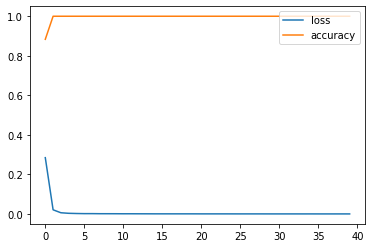

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


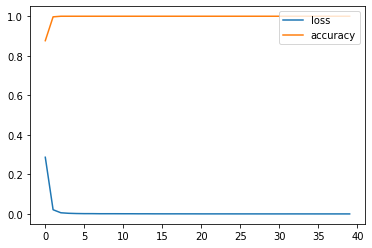

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


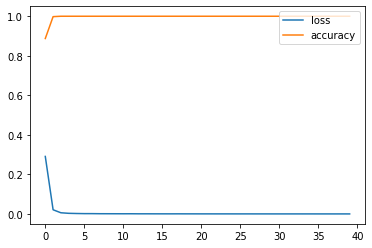

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


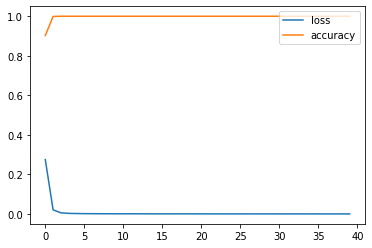

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


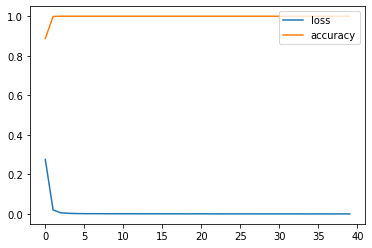

1.0

In [7]:
#三核 四折交叉验证最佳结果
outer = RepeatedStratifiedKFold(n_splits = 5,n_repeats=1,random_state=2652124)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128],batch_size=128,epochs=40,gpuid=3)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 5

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


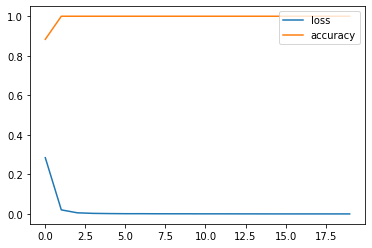

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


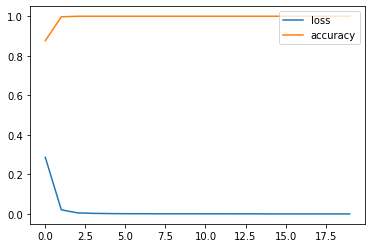

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


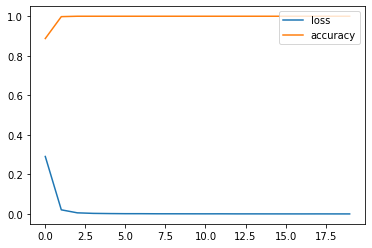

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


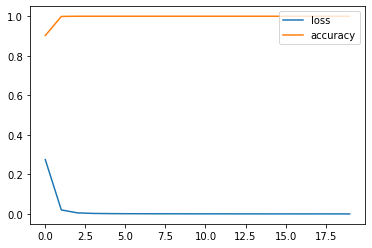

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


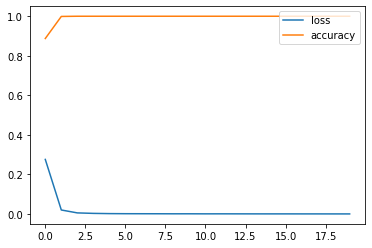

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


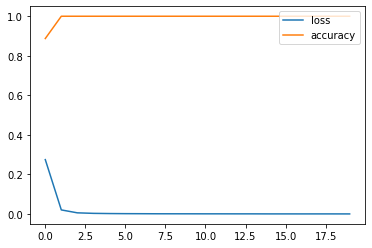

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


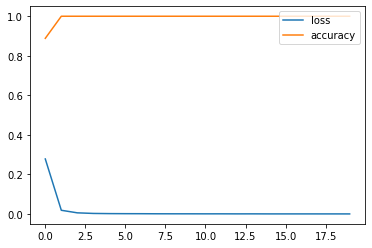

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


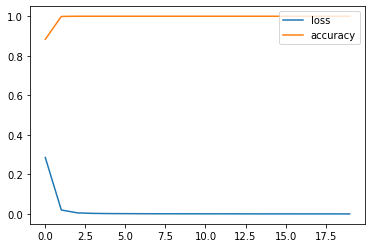

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


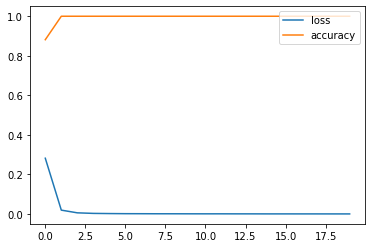

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


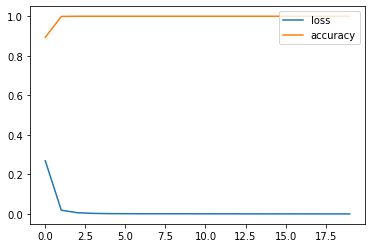

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


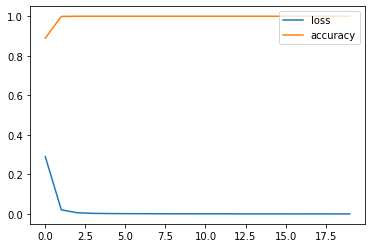

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


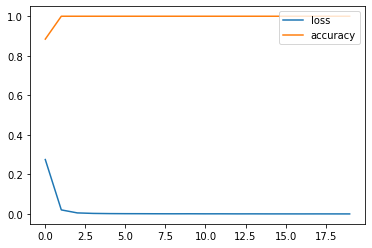

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


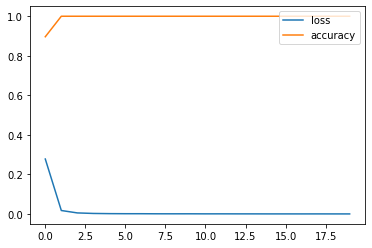

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


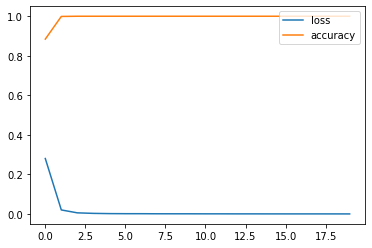

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


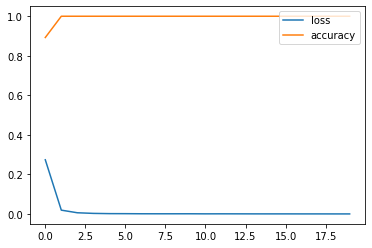

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


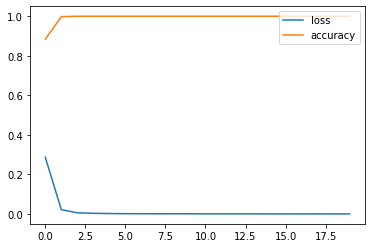

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


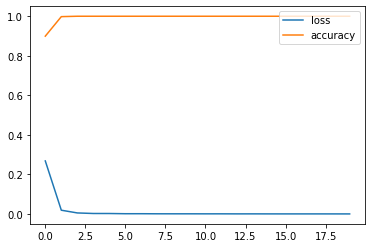

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


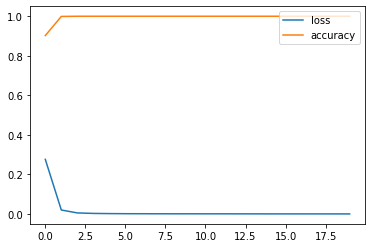

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


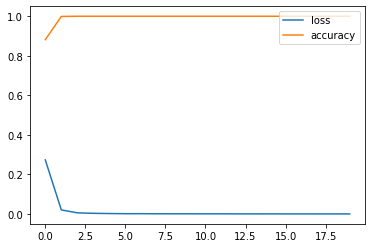

Auc =  1.0
Acc =  1.0
f1_score =  1.0
average_precision =  1.0
recall_score =  1.0


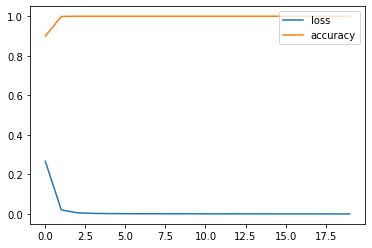

1.0

In [8]:
#三核 四折交叉验证最佳结果
outer = RepeatedStratifiedKFold(n_splits = 5,n_repeats=4,random_state=2652124)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',dense_layers=[128],batch_size=128,epochs=20,gpuid=3)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 20